In [75]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
import numpy as np

# Classification of Images of Handwritten 0 and 1

## Dataset

Structure of the training dataset
- The MNIST dataset has a total of  60,000 data points (rows in train_data) corresponding to digits ranging from 0 to 9
- The first column has the label of the datapoint ranging from 0 to 9
- The next 784 columns/features are each a 28x28 pixel grayscale image collapsed into a row. The dimension of the dataset is 784. Each of these values range from 0 to 275 where 0 corresponds to white and 255 corresponds to black and any value between 0 and 275 corresponds to a color which is a mix of black and white.

The testing dataset has the same form except it has 10000 data points. In order to get an idea of a picture of a digit inside the dataset, we will run the following code.

In [76]:
image_size = 28 # width and length are equal
data_path = "./dataset/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",", skiprows=1)
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",", skiprows=1)

In [77]:
print("Number of training datapoints: {}".format(train_data.shape[0]))
print("Number of testing datapoints: {}".format(test_data.shape[0]))

Number of training datapoints: 59999
Number of testing datapoints: 10000


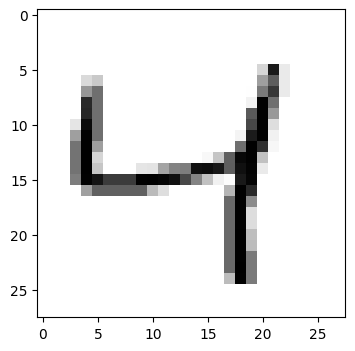

In [78]:
img = train_data[:, 1:][1].reshape((image_size, image_size))
plt.imshow(img, cmap="Greys")
plt.show()

In [79]:
img.shape

(28, 28)

# Applying Dimensionality Reduction Technique

The dimension of the data corresponds to the number of qubits required in order to encode the data for the quantum feature maps we will later initialize. Since quantum computers today can only manipulate 50 qubits, we cannot work with large number of qubits like 784, therefore encoding data with dimension 784 is not viable.

Therefore, we will have to make use of the truncated Singular Value Decomposition (SVD) and t-distributed stochastic neighbor embedding (t-SNE) methods to reduce the dimension down to 10 and then to 2.

We will first truncate the dataset to 10000 data points so that it becomes easier to apply the TruncatedSVD and TSNE techniques.

In [80]:
#Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

# Using SVD to reduce dimensions to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Use t-SNE technique to reduce dimensions to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [81]:
X_SVD.shape

(10000, 10)

In [82]:
train_data_features_reduced.shape

(10000, 2)

In [83]:
# plot out the dataset to see if there is some sort of clustering due to classification of digits in the reduced dataset. 

# function to help plot the 2-D dataset
def plotdataset(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

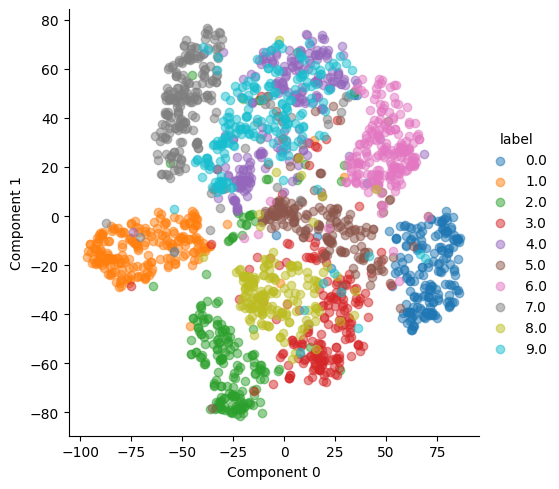

In [84]:
plotdataset(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

#### Observations
0 and 1 are well separated on opposite corners as they are easily distinguishable, however, 4 and 9 are overlapping as corresponding to purple and blue data points.



# Extracting and Normalizing Data

We will extract data points corresponding to the digits 0 and 1 from the reduced dataset and normalize their features to be between 0 and 2.

We need to normalize the data because the values will be inserted into a quantum feature map.

In [85]:
zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append([train_data_features_reduced[i]])

for i in range(10000):
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append([train_data_features_reduced[i]])
        
zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n

zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)

# The Variational Quantum Classifier

Similar to classical supervised machine learning algorithms, the VQC has a training stage (where data points with labels are provided and learning takes place) and a testing stage (where new data points without labels are provided which are then classified).

The main steps of this algorithm are:

1. Load Data onto the Quantum Computer by Applying a Quantum Feature Map Φ(x)‍

2. Build and apply short-depth Variational Circuit W(θ).



### Qiskit Feature Maps

Classical data needs to be mapped to Hilbert Space for Quantum operators to be able to operate on them. Feature maps encodes classical data into quantum state. Due to this classical data is now represented in a higher dimensional space. VQCs are linear classifiers in higher dimensional space

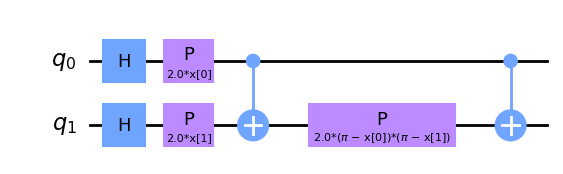

In [86]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
feature_dim = 2
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1)#, paulis = ['Z','X','ZY'])
pauli_feature_map.decompose().draw("mpl")

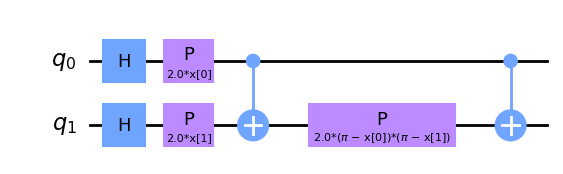

In [87]:
feature_dim = 2
pauli_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1)
pauli_feature_map.decompose().draw("mpl")

## Variational Circuits

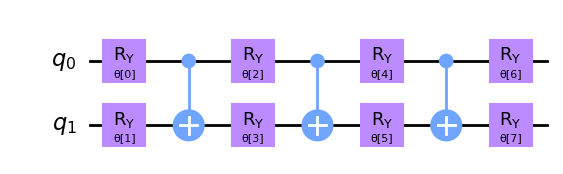

In [88]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import EfficientSU2

num_qubits = 2

variational_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)
variational_circ.decompose().draw("mpl")

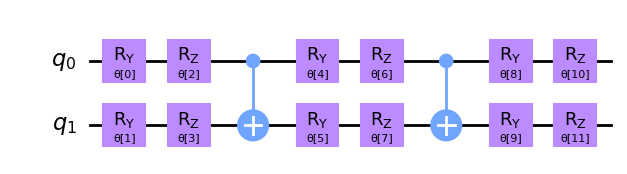

In [89]:
var_circuit = EfficientSU2(feature_dim, reps=2)
var_circuit.decompose().draw("mpl")

The first question you must ask when looking for an ansatz is: Can the trial state prepared by my ansatz circuit encode my solution? For example: Does your solution contain complex amplitudes? If yes, you need a circuit that contains complex amplitudes (such as EfficientSU2). If no, you could use one that has only real amplitudes (such as RealAmplitudes).

In [90]:
train_size = 20
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

In [91]:
zero_train.shape

(20, 1, 2)

In [92]:
#Train data
train_data = []
for i in range(train_size):
    train_data.append(np.append(zero_train[i], [0]))
for i in range(train_size):
    train_data.append(np.append(one_train[i], [1]))
np.random.shuffle(train_data)
    
final_data = []
lables = []
for point in train_data:
    final_data.append(point[:-1])
    lables.append(point[-1])
    
##Test data
test_data = []
for i in range(test_size):
    test_data.append(np.append(zero_test[i], [0]))
for i in range(test_size):
    test_data.append(np.append(one_test[i], [1]))
np.random.shuffle(test_data)
    
final_data_test = []
lables_test = []
for point in test_data:
    final_data_test.append(point[:-1])
    lables_test.append(point[-1])

In [93]:
final_data

[array([1.84262145, 0.9105283 ]),
 array([1.79167247, 0.99628401]),
 array([1.67427969, 0.88177699]),
 array([1.54212761, 0.76602674]),
 array([1.71249866, 0.70171368]),
 array([1.75192595, 0.68166161]),
 array([0.50598633, 0.96250212]),
 array([1.78534222, 0.78999352]),
 array([1.75333428, 0.6671561 ]),
 array([1.85427094, 0.82486236]),
 array([1.75553   , 0.65882337]),
 array([0.57300317, 0.9615621 ]),
 array([0.18660921, 0.80741668]),
 array([0.21782029, 0.81270075]),
 array([0.56771487, 0.98667222]),
 array([1.83172536, 0.78254545]),
 array([1.60282385, 0.75142002]),
 array([0.19419175, 0.93514228]),
 array([0.41579181, 0.97712576]),
 array([0.44066906, 0.89128369]),
 array([0.20251065, 0.84082389]),
 array([1.52809715, 0.71350735]),
 array([1.77504385, 0.98592579]),
 array([0.08802611, 0.8112182 ]),
 array([1.62848115, 0.60924733]),
 array([0.53988147, 0.55146992]),
 array([0.45868772, 0.93067175]),
 array([1.80898774, 0.72356784]),
 array([0.39009416, 0.99399078]),
 array([0.6117

In [94]:
lables

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0]

In [95]:
seed = 10598
feature_dim = np.array(final_data).shape[1]

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='linear')
feature_map.draw()

┌──────────────────────────┐
q_0: ┤0                         ├
     │  ZZFeatureMap(x[0],x[1]) │
q_1: ┤1                         ├
     └──────────────────────────┘

In [96]:
from  qiskit.algorithms.optimizers import COBYLA
cobyla = COBYLA(maxiter=500, tol=0.001)

The first question you must ask when looking for an ansatz is: Can the trial state prepared by my ansatz circuit encode my solution? For example: Does your solution contain complex amplitudes? If yes, you need a circuit that contains complex amplitudes (such as EfficientSU2). If no, you could use one that has only real amplitudes (such as RealAmplitudes).

In [97]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

var_circuit = EfficientSU2(2, reps=1)

In [98]:
var_circuit.draw()

┌────────────────────────────────────────────────────────┐
q_0: ┤0                                                       ├
     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                       ├
     └────────────────────────────────────────────────────────┘

In [99]:
from IPython.display import clear_output
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [100]:
# initilizing backend
seed = 10598
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}
from qiskit_machine_learning.algorithms.classifiers import neural_network_classifier
from qiskit_machine_learning.algorithms import VQC
# creating a quantum instance
from qiskit.utils.quantum_instance import QuantumInstance
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)

#initilizing VQC object
vqc = VQC(num_qubits=2, feature_map=feature_map, ansatz=var_circuit, loss='cross_entropy', optimizer=cobyla,quantum_instance=quantum_instance, callback = callback_graph)

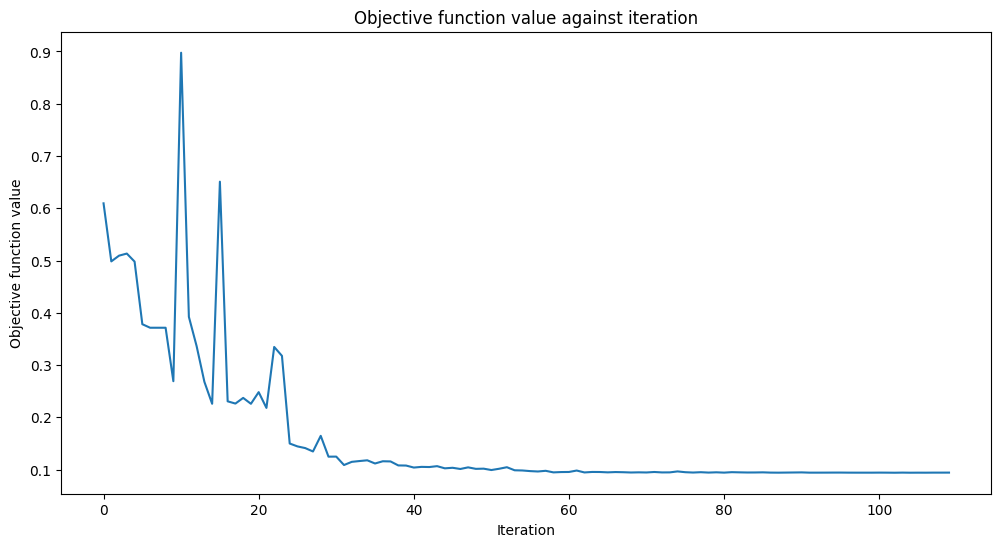

0.975

In [101]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(np.array(final_data), np.array(lables))

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(np.array(final_data), np.array(lables))

In [102]:
test_data = []
for i in range(test_size):
    test_data.append(np.append(zero_test[i], [0]))
for i in range(test_size):
    test_data.append(np.append(one_test[i], [1]))
np.random.shuffle(test_data)
    
final_data_test = []
lables_test = []
for point in test_data:
    final_data_test.append(point[:-1])
    lables_test.append(point[-1])

In [103]:
test_score_q4 = vqc.score(np.array(final_data_test), np.array(lables_test))
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the test dataset:     0.95
